## Q1a

Preprocessing consisted of shuffling and centering the data. Thus, the bias term of the solution of the new data set is 0, and the bias won't be unduly penalized by the $L_{2}$ Regularization. As such, the bias will be handled in the linear regression by way of transforming the data so the bias = 0, rather than adding 1 to each input.

Centering the data was done as follows:

$\overline{x} = \frac{1}{m} \sum_{i=1}^{m}x_{i}$ 

$\overline{y} = \frac{1}{m} \sum_{i=1}^{m}y_{i}$ 

New data set: {($x_{i} - \overline{x}$,$y_{i} - \overline{y}$)} $\forall i = 1,...,m$

Moreover, I did min-max normalization:

$x' = \frac{x - min(x)}{max(x) - min(x)}$

In [77]:
import numpy as np
from numpy import genfromtxt
from numpy.linalg import inv
from numpy.linalg import norm
from matplotlib import pyplot as plt
import math

In [78]:
# Clean csv format

#with open('hw1-q1x-clean.csv','w') as f:
#    with open('hw1-q1x.csv','r') as fp:
#        lines = fp.readlines()
#        for line in lines:
#            line = line.strip().split(' ')
#            f.write(line[0] + ',' + line[-1] + '\n')

In [79]:
x = genfromtxt('hw1-q1x-clean.csv', delimiter=',')
y = genfromtxt('hw1-q1y.csv', delimiter=',')

split_percent = 0.8
instances = x.shape[0]

In [80]:
# shuffle
y_column = y.reshape(instances,1)
data = np.hstack((x,y_column))

np.random.shuffle(data)
data
x = data[:,0:2]
y = data[:,2:3].reshape(instances)

In [81]:
# Preprocessing -> centering
x_sample_mean = np.sum(x,axis=0)/instances
y_sample_mean = np.sum(y,axis=0)/instances

In [82]:
x_centered = x - x_sample_mean
y_centered = y - y_sample_mean

minimum_x = np.amin(x_centered,axis=0)
maximum_x = np.amax(x_centered,axis=0)


x_pre = (x_centered - minimum_x)/(maximum_x - minimum_x)
y_pre = y_centered

In [83]:
# split
train_x = x_pre[0:int(split_percent*instances)]
test_x = x_pre[int(split_percent*instances):instances]

train_y = y_pre[0:int(split_percent*instances)]
test_y = y_pre[int(split_percent*instances):instances]

## Q1b

In [84]:
lamb = [0,0.1,1,10,100,1000,10000,100000]
minimum = 0
minError = -1
trainError = -1
testError = -1
rmses_train = []
rmses_test = []
l2_norm = []
w1 = []
w2 = []

def rmse(x,y,w_1,w_2):
    summation = 0.0
    samples = x.shape[0]
    for i in range(x.shape[0]):
        y_hat = 0 + w_1*x[i][0] + w_2*x[i][1] # include bias, which is 0
        y_act = y[i]
        y_result = y_hat - y_act
        summation +=y_result*y_result
    return math.sqrt(summation / samples)

for l in lamb:
    regularization = np.identity(2)*l
    w_star = np.dot(np.dot(inv(np.dot(np.transpose(train_x),train_x) + regularization), np.transpose(train_x)),train_y)
    b_1 = w_star[0]
    b_2 = w_star[1]
    train_error = rmse(train_x,train_y,b_1,b_2)
    test_error = rmse(test_x,test_y,b_1,b_2)
    
    if minError == -1:
        minError = train_error + test_error
        trainError = train_error
        testError = test_error
        minimum = l
    elif train_error + test_error < minError:
        minError = train_error + test_error
        trainError = train_error
        testError = test_error
        minimum = l
    
    rmses_train.append(train_error)
    rmses_test.append(test_error)
    
    l2_norm.append(norm(w_star,2))
    w1.append(b_1)
    w2.append(b_2)

In [85]:
minimum

1

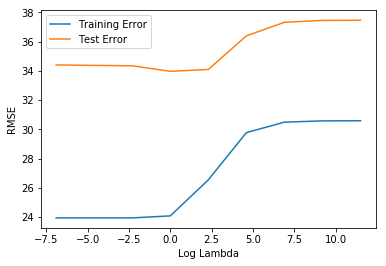

In [86]:
# approximate log(0) with log(0.0000000000001)
lamb_approx = [0.001,0.1,1,10,100,1000,10000,100000]
loglamb = [math.log(y) for y in lamb_approx]
plt.plot(loglamb,rmses_train,label="Training Error")
plt.xlabel("Log Lambda")
plt.ylabel("RMSE")
plt.plot(loglamb,rmses_test,label="Test Error")
plt.legend()
plt.show()

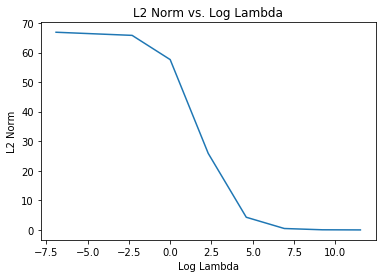

In [87]:
# approximate log(0) with log(0.0000000000001)
plt.plot(loglamb,l2_norm)
plt.title("L2 Norm vs. Log Lambda")
plt.xlabel("Log Lambda")
plt.ylabel("L2 Norm")
plt.show()

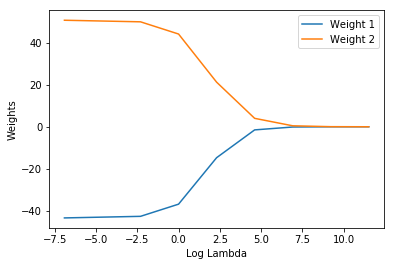

In [88]:
plt.plot(loglamb,w1,label="Weight 1")
plt.xlabel("Log Lambda")
plt.ylabel("Weights")
plt.plot(loglamb,w2,label="Weight 2")
plt.legend()
plt.show()

#### Comments:

In the first graph, one can see that, as you increase the regularization constant, you underfit the data more and more. The minimum error occurs at $\lambda = 0$.

In the second graph, L2 Norm increases as the regularization constant decreses in value. This makes sense, since the larger the regularization constant, the more the magnitude of the weights will be penalized.

Similarly, in the third graph, weight magnitudes increase as lambda decreases.

## Q1c

Cross-Validation

In [89]:
k = 5
train_instances = train_x.shape[0]
fold_start = [int(i*train_instances/k) for i in range(k)]
fold_end = [int((i+1)*train_instances/k) for i in range(k)]

In [90]:
aveErrors = {}
for l in lamb:
    errors = []
    for i in range(k):
        validation_fold_x = train_x[fold_start[i]:fold_end[i]]
        validation_fold_y = train_y[fold_start[i]:fold_end[i]]
        
        train_fold_x = np.vstack((train_x[:fold_start[i]],train_x[fold_end[i]:]))
        train_fold_y = np.hstack((train_y[:fold_start[i]],train_y[fold_end[i]:]))
    
        regularization = np.identity(2)*l
        w_star = np.dot(np.dot(inv(np.dot(np.transpose(train_fold_x),train_fold_x) + regularization), np.transpose(train_fold_x)),train_fold_y)
        b_1 = w_star[0]
        b_2 = w_star[1]
        train_error = rmse(train_fold_x,train_fold_y,b_1,b_2)
        validation_error = rmse(validation_fold_x,validation_fold_y,b_1,b_2)
        
        errors.append(validation_error)
        print("Lambda %f, Fold %d, Training Error %f, Validation Error %f" % (l,(i+1),train_error,validation_error))
    aveErrors[str(l)] = sum(errors) / len(errors)
    print()

Lambda 0.000000, Fold 1, Training Error 23.240121, Validation Error 27.022052
Lambda 0.000000, Fold 2, Training Error 23.358083, Validation Error 26.732050
Lambda 0.000000, Fold 3, Training Error 24.348623, Validation Error 22.955850
Lambda 0.000000, Fold 4, Training Error 23.334219, Validation Error 26.436963
Lambda 0.000000, Fold 5, Training Error 24.884524, Validation Error 20.491130

Lambda 0.100000, Fold 1, Training Error 23.243241, Validation Error 26.992961
Lambda 0.100000, Fold 2, Training Error 23.360911, Validation Error 26.757933
Lambda 0.100000, Fold 3, Training Error 24.351248, Validation Error 23.000574
Lambda 0.100000, Fold 4, Training Error 23.336463, Validation Error 26.519837
Lambda 0.100000, Fold 5, Training Error 24.888050, Validation Error 20.310834

Lambda 1.000000, Fold 1, Training Error 23.462645, Validation Error 26.961962
Lambda 1.000000, Fold 2, Training Error 23.559989, Validation Error 27.119571
Lambda 1.000000, Fold 3, Training Error 24.536777, Validation 

In [91]:
aveErrors

{'0': 24.727608890116404,
 '0.1': 24.71642775025486,
 '1': 24.82411375047232,
 '10': 27.45274562830162,
 '100': 29.89061760273308,
 '1000': 30.232563241912413,
 '10000': 30.267248213678478,
 '100000': 30.27072297183424}

In [92]:
minCV = -1
minL = -1

for l in lamb:
    if minCV == -1 or minCV > aveErrors[str(l)]:
        minL = l
        minCV = aveErrors[str(l)]
        
print("Lamb: " + str(minL) + "; CV Error: " + str(minCV))

Lamb: 0.1; CV Error: 24.71642775025486


#### Comments

The best $\lambda$, as determined by cross-validation, is $\lambda = 0.1$.

How I got the best $\lambda$: 

    For each lambda:

        for each fold of the cross-validation:
    
            Gather validation Root-Mean-Square Error on Validation set
        
        Average the RMSE for this lambda across the folds (for the validation sets)

    Select lambda with the lowest average validation set RMSE 
    
This lambda value differs from the lambda of Q1b. Q1b had lowest RMSE at $\lambda = 1$, whereas Q1c had lowest average RMSE at $\lambda = 0.1$. The differences might be due to the partitioning in the dataset. In Q1b, we used the whole training dataset to perform the regression, whereas in Q1c we used 80% of the training dataset, with 20% left out for valdiation. Thus, our regression could have overfit more to the smaller amount of data during cross-validation, and thus, higher regulation would have produced better results.

## Q1d

Several issues would crop up if one performed cross-validation on data that was sorted in increasing value of the target variable $y$:

1. The training/test/validation sets would not be representative of the overall distribution of the data. During the hyperparameter tuning phase, the model would be trained on a range of $y$ values that do not occur in the validation data. Thus, the model wouldn't be able to interpolate the validation data as well, since there's a range of response variables that the model has never experienced. Similarly, for the testing stage, the test data would consist of a range of response variables that the model has never seen, and thus, the model wouldn't perform as well.

2. Without shuffling the data, the regression would start to overfit and model the arbitrary structure of increasing $y$ values. This would reduce the generalization of the model to new values, since the sorting is random and not a feature of the data, and this structure wouldn't continue with new instances. 

## Q1e
From:

\begin{bmatrix}
    x_{11}       & x_{12} \\
    x_{21}       & x_{22} \\
    \dots \\
    x_{m1}       & x_{m2} 
\end{bmatrix}

To (Apply Gaussian Basis functions per variable):

\begin{bmatrix}
    e^{-\frac{(x_{11} - \mu_{1})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{11} - \mu_{2})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{11} - \mu_{3})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{11} - \mu_{4})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{11} - \mu_{5})^{2}}{2\sigma^{2}}} & e^{-\frac{(x_{12} - \mu_{1})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{12} - \mu_{2})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{12} - \mu_{3})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{12} - \mu_{4})^{2}}{2\sigma^{2}}}       & e^{-\frac{(x_{12} - \mu_{5})^{2}}{2\sigma^{2}}}        \\
    \dots \\
\end{bmatrix}




In [93]:
sigmas = [0.1, 0.5, 1.0, 5.0]
mean = [-1.0, -0.5, 0.0, 0.5, 1.0]

def gaussian(x,sigma,mean):
    val = -(((x - mean)**2)/(2*sigma**2))
    return math.exp(val)


def phi(sigma, means, x):
    instances = x.shape[0]
    gaussians = x.shape[1] * len(means)
    new_x = np.empty((instances,gaussians))
    
    for i in range(instances):
        for j in range(gaussians):
            if j < gaussians/2:
                new_x[i][j] = gaussian(x[i][0],sigma,means[j%5])
            else:
                new_x[i][j] = gaussian(x[i][1],sigma,means[j%5])
                
    return new_x

## Q1f

In [94]:
def rmseGeneralize(x,y,w):
    summation = 0.0
    samples = x.shape[0]
    for i in range(x.shape[0]):
        y_hat = sum([w[j]*x[i][j] for j in range(x.shape[1])])
        y_act = y[i]
        y_result = y_hat - y_act
        summation +=y_result*y_result
    return math.sqrt(summation / samples)

train_phi_error = []
testing_phi_error = []

for sigma in sigmas:
    train_phi = phi(sigma,mean,train_x)
    test_phi = phi(sigma,mean,test_x)
    w_star = np.dot(np.dot(inv(np.dot(np.transpose(train_phi),train_phi)), np.transpose(train_phi)),train_y)
    
    train_error = rmseGeneralize(train_phi,train_y,w_star)
    test_error = rmseGeneralize(test_phi,test_y,w_star)
    
    train_phi_error.append(train_error)
    testing_phi_error.append(test_error)

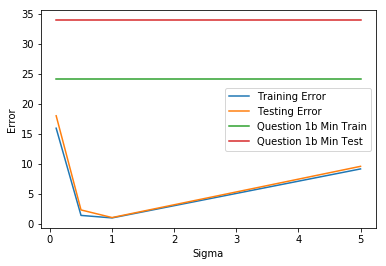

In [95]:
plt.plot(sigmas,train_phi_error,label="Training Error")
plt.plot(sigmas,testing_phi_error,label="Testing Error")
question1b_train = [trainError for i in sigmas]
question1b_test = [testError for i in sigmas]

plt.xlabel("Sigma")
plt.ylabel("Error")

plt.plot(sigmas,question1b_train,label="Question 1b Min Train")
plt.plot(sigmas,question1b_test,label="Question 1b Min Test")

plt.legend()
plt.show()

#### Comments

The $\sigma^{2}$ term controls the smoothness of our model, with smaller values of $\sigma$ leading to narrower bell-curve Gaussian bases which respond to local changes more and larger values of $\sigma$ which are more smooth. Thus, smaller values of $\sigma$ will cause the function to overfit the data, as it responds to local changes more. Larger values of $\sigma$ will lead, more and more, to underfitting.  

In terms of the bias-variance tradeoff, smaller values of $\sigma$ increase the complexity of the model which reduces the bias error but increases the error due to variance. Larger values of $\sigma$ decreases the complexity of the model, which reduces the variance error but increases the error due to restricting the hypothesis class (bias error)

## Q1g

Recall the gaussian basis function: $\phi_{k}(x) = e^{-\frac{(x-\mu_{k})}{2\sigma^2}}$

$\sigma$ controls the width/activation radius 

$\mu_{k}$ controls the position along the x-axis

Thus, to learn the optimal $\mu$ for the basis functions, we could utilize an unsupervised cluster analysis (kmeans) to find the means for the C clusters and then continue with Ridge regression.

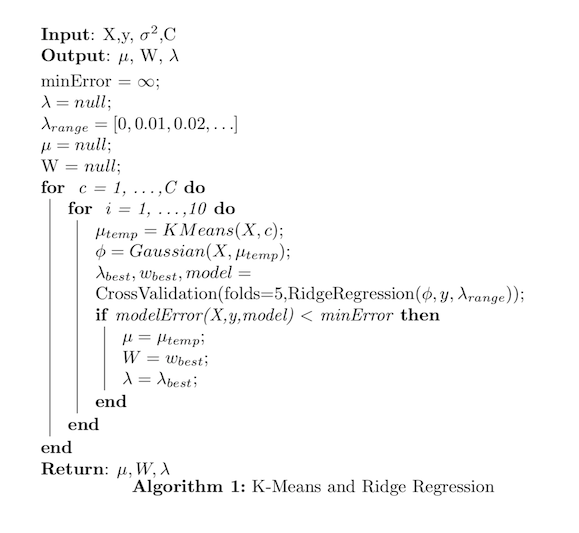

#### Comments

The data (X,y), $\sigma$, and the number of clusters C are inputs. I define a universe of $\lambda$ values, and set the returned values (optimal means/clusters $\mu$, weights W, and optimal $\lambda$) to null.

For a given cluster number c ($c = 1,2,\dots C$), I use a KMeans algorithm to find c means and set the $\mu_{temp}$ vector to these means. Using $\mu_{temp}$, the data is projected and RidgeRegression (with cross validation) is performed to find the best $\lambda$, weights, and model for this iteration.

NOTE: KMeans (using kmeans++ to set the initial values) does not necessarily converge to a global minima. The setting of the initial values is very important to the competitiveness of the KMeans clusters to the optimal clusters. Thus, for each cluster $c = 1,2,\dots C$, I run the algorithm 10 times ($i = 1,2, \dots 10$). This will encourage better performance, as several random initial values (per cluster number) will be explored. 

## Q1h

Does the algorithm converge?

Yes. Regardless of the optimal $\mu$ placement and clusters, the underlying error function we are trying to minimize is that of the Ridge Regression error function. Since the Ridge Regression error function is convex, there is a global minimum and if we utilize gradient descent (with a learning rate $\alpha$ that is not too large), we will converge.

Locally or Globally optimal solution?

As stated, Ridge Regression optimizes for a convex error function, so gradient descent with an appropriate learning rate will converge to a global minimum. K-Means finds a better feature mapping, but the underlying ridge regression is still intact.

## Q1i

### d-degree polynomial regression

In [969]:
x = genfromtxt('hw1-q1x-clean.csv', delimiter=',')
y = genfromtxt('hw1-q1y.csv', delimiter=',')

split_percent = 0.8
instances = x.shape[0]

# shuffle
y_column = y.reshape(instances,1)
data = np.hstack((x,y_column))

np.random.shuffle(data)

In [970]:
x = data[:,1]
y = data[:,2:3].reshape(instances)

In [971]:
# Preprocessing -> centering
x_sample_mean = np.sum(x,axis=0)/instances
y_sample_mean = np.sum(y,axis=0)/instances

x_centered = x - x_sample_mean
y_centered = y - y_sample_mean

minimum_x = np.amin(x_centered,axis=0)
maximum_x = np.amax(x_centered,axis=0)


x_pre = (x_centered - minimum_x)/(maximum_x - minimum_x)
y_pre = y_centered

# split
train_x = x_pre[0:int(split_percent*instances)]
test_x = x_pre[int(split_percent*instances):instances]

train_y = y_pre[0:int(split_percent*instances)]
test_y = y_pre[int(split_percent*instances):instances]

In [972]:
valRange = np.arange(0,1.01,0.01)
def polynomial(x,d):
    instances = x.shape[0]
    new_x = np.empty((instances,d))
    for i in range(instances):
        for j in range(1,d+1):
            new_x[i][j-1] = x[i]**j
    return new_x

def f(d,w):
    values = []
    for i in range(len(valRange)):
        values.append(sum([w[j]*valRange[i]**(j+1) for j in range(d)]))
    return values

In [973]:
degrees = [1,2,3,5,9]
k = 5
train_instances = train_x.shape[0]
fold_start = [int(i*train_instances/k) for i in range(k)]
fold_end = [int((i+1)*train_instances/k) for i in range(k)]

In [974]:
aveErrors = {}
testErrors = {}
values = {}
for d in degrees:
    errors = []
    for i in range(k):
        validation_fold_x = train_x[fold_start[i]:fold_end[i]]
        validation_fold_y = train_y[fold_start[i]:fold_end[i]]
        
        train_fold_x = np.hstack((train_x[:fold_start[i]],train_x[fold_end[i]:]))
        train_fold_y = np.hstack((train_y[:fold_start[i]],train_y[fold_end[i]:]))

        train_phi = polynomial(train_fold_x,d)
        validation_phi = polynomial(validation_fold_x,d)
        w_star = np.dot(np.dot(inv(np.dot(np.transpose(train_phi),train_phi)), np.transpose(train_phi)),train_fold_y)
        
        validation_error = rmseGeneralize(validation_phi,validation_fold_y,w_star)
        
        errors.append(validation_error)
    aveErrors[d] = sum(errors) / len(errors)
    
    phi = polynomial(train_x,d)
    w_star = np.dot(np.dot(inv(np.dot(np.transpose(phi),phi)), np.transpose(phi)),train_y)
    
    testErrors[d] = rmseGeneralize(polynomial(test_x,d),test_y,w_star)
    
    values[d] = f(d,w_star)

In [975]:
aveErrors

{1: 28.801217332246534,
 2: 10.033746054863498,
 3: 9.394744708855315,
 5: 8.526761363637004,
 9: 8.544893530780973}

In [976]:
testErrors[5]

7.517006314015492

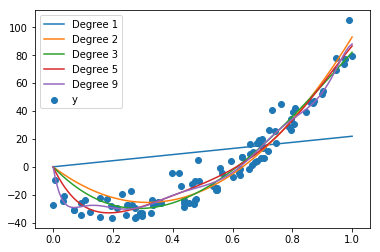

In [977]:
plt.scatter(x_pre,y_pre,label="y")
plt.plot(valRange,values[1],label="Degree 1")
plt.plot(valRange,values[2],label="Degree 2")
plt.plot(valRange,values[3],label="Degree 3")
plt.plot(valRange,values[5],label="Degree 5")
plt.plot(valRange,values[9],label="Degree 9")
plt.legend()
plt.show()

#### Thus, by 5-fold cross validation, degree 5 has the smallest averaged validation error.

### Ridge Regression

In [978]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [979]:
poly = PolynomialFeatures(degree=9)
X_ = poly.fit_transform(train_x.reshape(-1, 1))
Xtest_ = poly.fit_transform(test_x.reshape(-1, 1))

params={'alpha': [0.01,0.1,1,10]}
clf = Ridge()
clf = GridSearchCV(clf,params,cv=5,verbose = 1)
clf.fit(X_, train_y)
print(clf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [980]:
clf.best_params_

{'alpha': 0.01}

In [981]:
clf.best_estimator_.coef_

array([  0.        , -26.29787104,  73.78596531,  57.17658817,
        22.62548131,  -1.7237419 , -12.11463796, -10.85668445,
        -1.19107311,  13.99295192])

In [982]:
def rmseNoWeights(y,y_hat):
    if len(y) != len(y_hat):
        print("ERROR")
        return
    summation = 0.0
    for i in range(len(y)):
        y_result = y_hat[i] - y[i]
        summation += y_result*y_result
    return math.sqrt(summation / len(y))

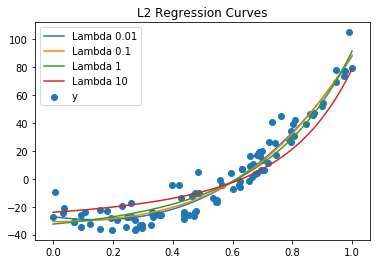

In [983]:
testErrors = {}


plt.scatter(x_pre,y_pre,label="y")
for lamb in params['alpha']:
    clf = Ridge()
    clf = GridSearchCV(clf,{'alpha': [lamb]})
    clf.fit(X_, train_y)
    vals = poly.fit_transform(valRange.reshape(-1, 1))
    plt.plot(valRange,clf.predict(vals),label="Lambda " + str(lamb))
    
    testErrors[lamb] = rmseNoWeights(test_y,clf.predict(Xtest_))
    
plt.title("L2 Regression Curves")
plt.legend()
plt.show()

In [984]:
testErrors[0.01]

8.218248135671455

### Lasso Regression

In [985]:
from sklearn.linear_model import Lasso

In [986]:
params={'alpha': [0.01,0.1,1,10]}
clf = Lasso(max_iter=100000)
clf = GridSearchCV(clf,params,cv=5,verbose = 1)
clf.fit(X_, train_y)
print(clf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [987]:
clf.best_params_

{'alpha': 0.1}

In [988]:
clf.best_estimator_.coef_

array([ 0.        ,  0.        , 17.98061081, 99.45386241,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

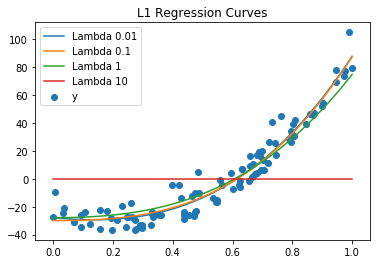

In [989]:
testErrors = {}

plt.scatter(x_pre,y_pre,label="y")
for lamb in params['alpha']:
    clf = Lasso(max_iter=10000)
    clf = GridSearchCV(clf,{'alpha': [lamb]})
    clf.fit(X_, train_y)
    vals = poly.fit_transform(valRange.reshape(-1, 1))
    plt.plot(valRange,clf.predict(vals),label="Lambda " + str(lamb))
    
    testErrors[lamb] = rmseNoWeights(test_y,clf.predict(Xtest_))
    
plt.title("L1 Regression Curves")
plt.legend()
plt.show()

In [991]:
testErrors[0.1]

8.715820390437463

#### Comments

- In the d-degree polynomial regression, the optimal degree was found to be $d = 5$, and for this degree, we had: $Test Error = 7.517$

- For Ridge regression, the optimal $\lambda$ was $0.01$. We had $Test Error = 8.218$. We got weights: 

[  0.        , -26.29787104,  73.78596531,  57.17658817,
        22.62548131,  -1.7237419 , -12.11463796, -10.85668445,
        -1.19107311,  13.99295192]


- For Lasso regression, the optimal $\lambda$ was $0.1$. We had $Test Error = 8.71$. We got weights: 

[ 0.        ,  0.        , 17.98061081, 99.45386241,  0.        ,0.        ,  0.        ,  0.        ,  0.        ,  0.        ]

The weights of ridge regression point to the degree $d = 5$ that we found previously, as the only weights above 15 are of the inputs associated with degree 3, 4, and 5. Moreover, the weights of Lasso seem to point at a degree of 4, since the only weights with values are those weights associated with degree 3 and 4. Thus, this suggests that the underlying polynomial seems to be of degree 4 or 5. 